# Estimation of a Gaussian Mixture Model with Gradient Descent on the NLL

In [1]:
%matplotlib inline
from math import sqrt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
try:
    sess
except NameError:
    sess = tf.InteractiveSession()

/home/ogrisel/code/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload
%autoreload 2

## Parameterization of a covariance matrix

To define the probability density function of a multivariate Gaussian distribution, we need to parameterize the precision matrix (noted P) which is the inverse of the covariance matrix (noted C). Both matrices need to be symmetric positive definite for the density function to be well-defined.

We parameterize a precision matrix as the sum of a full rank positive diagonal matrix and a low rank symmetric and positive semidefinite matrix. P is guaranteed to always be symmetric and positive definite thanks to the following parameterization.

In [3]:
batch_size = 10
n_features = 2
cov_rank = 1
init_seed = 1

X = tf.placeholder(shape=(batch_size, n_features), dtype=tf.float32, name='X')

In [4]:
# with tf.variable_scope('precision'):
#     d = tf.Variable(tf.truncated_normal(shape=(n_features,),
#                                         stddev=1 / sqrt(n_features),
#                                         dtype=tf.float32,
#                                         seed=init_seed),
#                     name='d')
#     H = tf.Variable(tf.truncated_normal(shape=(n_features, cov_rank),
#                                         stddev=1 / sqrt(n_features),
#                                         dtype=tf.float32,
#                                         seed=init_seed),
#                     name='')

#     P = tf.add(tf.diag(tf.exp(d)), tf.matmul(H, tf.transpose(H)), name='P')

# sess.run(tf.initialize_all_variables())

Alternative parameterization: `P = (D + L).(DT + LT)` with L strictly lower triangular such that `det(P) == det(diag(D) ** 2`).  `(D + L)` can be seen as the Cholesky factorization of `P`.

In [5]:
with tf.variable_scope('precision'):
    mu = tf.Variable(tf.zeros(shape=(n_features,), dtype=tf.float32),
                     name='mu')
    d = tf.Variable(tf.truncated_normal(shape=(n_features,),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='d')
    H = tf.Variable(tf.truncated_normal(shape=(n_features, n_features),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='W')
    M = tf.constant(np.tril(np.ones(shape=(n_features, n_features), dtype=np.float32), k=-1),
                    name='triangular_mask')
    L = tf.add(tf.diag(tf.exp(d)), tf.mul(M, H), name='L')
    P = tf.matmul(L, tf.transpose(L), name='P')

sess.run(tf.initialize_all_variables())

In [6]:
P.eval()

array([[ 0.31746829,  0.02602817],
       [ 0.02602817,  8.16454697]], dtype=float32)

In [7]:
tf.matrix_determinant(P).eval()

2.5913072

## Optimization of a loss function that depends on the determinant w.r.t. of C

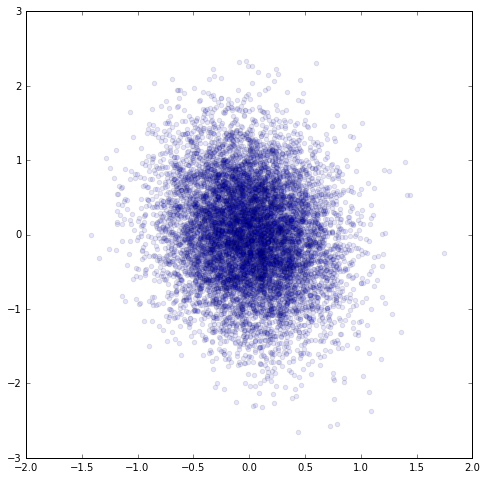

In [8]:
sess.run(tf.initialize_all_variables())
rng = np.random.RandomState(42)
C = np.linalg.inv(P.eval())
samples = rng.multivariate_normal(np.zeros(n_features), C, size=10000)
plt.figure(figsize=(8, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [9]:
det = tf.matrix_determinant(P)
loss = (det - 42) ** 2
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)
sess.run(tf.initialize_all_variables())

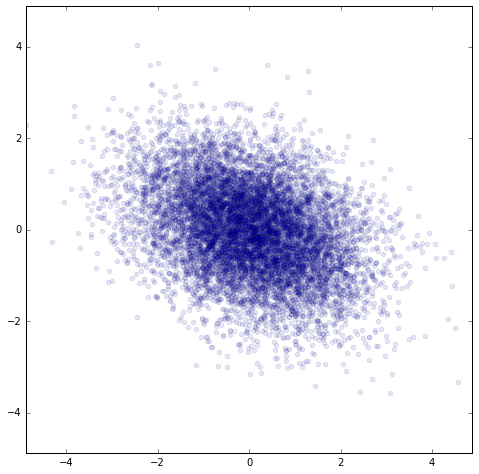

In [10]:
C = np.linalg.inv(P.eval())
samples = np.random.multivariate_normal(np.zeros(n_features), C, size=10000)
max_abs = np.abs(samples).max()
plt.figure(figsize=(8, 8))
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [11]:
P.eval()

array([[ 0.74422759,  0.31463081],
       [ 0.31463081,  1.14071095]], dtype=float32)

In [12]:
losses, determinants = [], []
losses.append(loss.eval())
determinants.append(det.eval())
for i in range(1000):
    train_op.run()
    losses.append(loss.eval())
    determinants.append(det.eval())

In [13]:
losses[0], losses[-1]

(1701.5663, 1.4551915e-11)

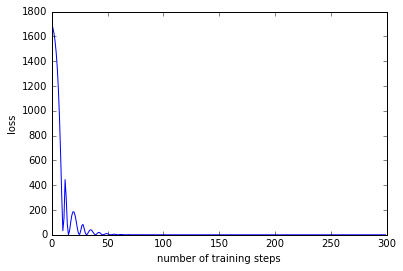

In [14]:
plt.plot(losses[:300])
plt.ylabel('loss'),
plt.xlabel('number of training steps');

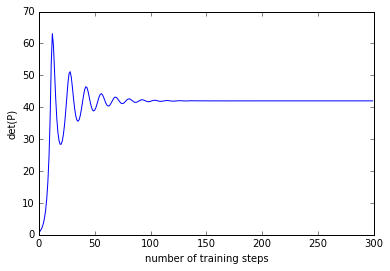

In [15]:
plt.plot(determinants[:300])
plt.ylabel('det(P)'),
plt.xlabel('number of training steps');

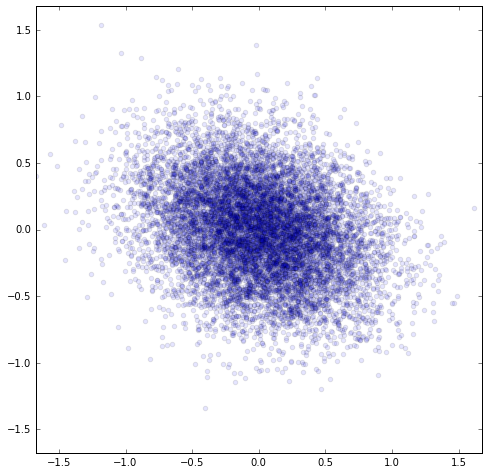

In [16]:
C = np.linalg.inv(P.eval())
samples = np.random.multivariate_normal(np.zeros(n_features), C, size=10000)
max_abs = np.abs(samples).max()
plt.figure(figsize=(8, 8))
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1);

In [17]:
P.eval()

array([[ 5.56945992,  1.848279  ],
       [ 1.848279  ,  8.15449429]], dtype=float32)

In [18]:
tf.matrix_determinant(P).eval()

41.999996

In [19]:
det_C = np.linalg.det(C)
det_C

0.023809526

In [20]:
1 / det_C

41.999995931983385

In [21]:
tf.reduce_prod(tf.exp(d)).eval() ** 2

41.99999185934962

In [22]:
logdet_C = np.log(det_C)
logdet_C

-3.7376695

In [23]:
2 * tf.reduce_sum(d).eval()

3.7376694679260254

## Fitting a single multi-variate Gaussian model

In [24]:
def sample_batch(batch_size):
    return rng.multivariate_normal(mean=[1, 1], cov=[[1.5, -.9], [-.9, 1.5]],
                                 size=batch_size).astype(np.float32)

X_data = sample_batch(batch_size=100)

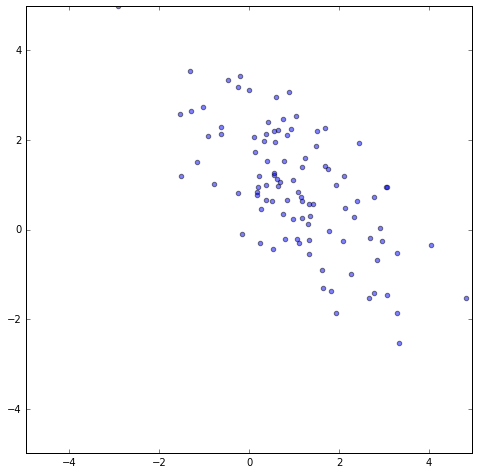

In [25]:
max_abs = np.abs(X_data).max()
plt.figure(figsize=(8, 8))
plt.xlim(-max_abs, max_abs)
plt.ylim(-max_abs, max_abs)
plt.scatter(X_data[:, 0], X_data[:, 1], alpha=0.5);

In [26]:
X = tf.placeholder(shape=(None, n_features), dtype=tf.float32, name='X')

with tf.variable_scope('precision'):
    mu = tf.Variable(tf.zeros(shape=(n_features,), dtype=tf.float32),
                     name='mu')
    d = tf.Variable(tf.truncated_normal(shape=(n_features,),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='d')
    H = tf.Variable(tf.truncated_normal(shape=(n_features, n_features),
                                        stddev=1 / sqrt(n_features),
                                        dtype=tf.float32,
                                        seed=init_seed),
                    name='W')
    # M is an element-wise mask to set all diagonal and triangular uppper entries of
    # of H to zero:
    M = tf.constant(np.tril(np.ones(shape=(n_features, n_features), dtype=np.float32), k=-1),
                    name='triangular_mask')
    L = tf.add(tf.diag(tf.exp(d)), tf.mul(M, H), name='L')
    P = tf.matmul(L, tf.transpose(L), name='P')


def log_likelihood(X, mu, P, d):
    X_mu = X - mu
    X_muTPX_mu = tf.reduce_sum(tf.mul(X_mu, tf.matmul(X_mu, P)),
                               reduction_indices=1)
    # logdet(C) = -logdet(P) as C is the inverse of P
    # logdet(P) = 2 * logdet(L) = 2 * sum_i d_i 
    return -0.5 * n_features * tf.log(2 * np.pi) + tf.reduce_sum(d) - 0.5 * X_muTPX_mu

In [27]:
nll_loss = -tf.reduce_mean(log_likelihood(X, mu, P, d))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
sgd_learning_rate = tf.Variable(np.array(0.1, dtype=np.float32), name='learning_rate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=sgd_learning_rate)
train_op = optimizer.minimize(nll_loss)
sess.run(tf.initialize_all_variables())

In [28]:
mu.eval()

array([ 0.,  0.], dtype=float32)

In [29]:
P.eval()

array([[ 0.31746829,  0.02602817],
       [ 0.02602817,  8.16454697]], dtype=float32)

In [30]:
d.eval()

array([-0.57368863,  1.04976988], dtype=float32)

In [31]:
sess.run(nll_loss, feed_dict={X: X_data})

13.072657

In [32]:
from gmmsgd import EpochSampler

batch_size = 10
patience = 3
X_train = sample_batch(int(1e2))
X_val = sample_batch(int(1e3))
X_test = sample_batch(int(1e3))

val_losses = [nll_loss.eval(feed_dict={X: X_val})]
best_val_loss = val_losses[0]
train_losses = [nll_loss.eval(feed_dict={X: X_train})]
n_samples_seen = [0]

batch_sampler = EpochSampler(X_train, n_epochs=100, batch_size=batch_size,
                             random_seed=0)
for n_seen, epoch, (X_batch,) in iter(batch_sampler):
    train_op.run(feed_dict={X: X_batch})
    if n_seen % 100 == 0:
        n_samples_seen.append(n_seen)
        val_loss = nll_loss.eval(feed_dict={X: X_val})
        val_losses.append(val_loss)
        train_losses.append(nll_loss.eval(feed_dict={X: X_train}))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
#             print(nll_loss.eval(feed_dict={X: X_test}))
            # TODO: snapshot model parameters
        else:
            patience -= 1
            if patience == 0:
                break
#             sgd_learning_rate.assign(sgd_learning_rate.eval() / 10)

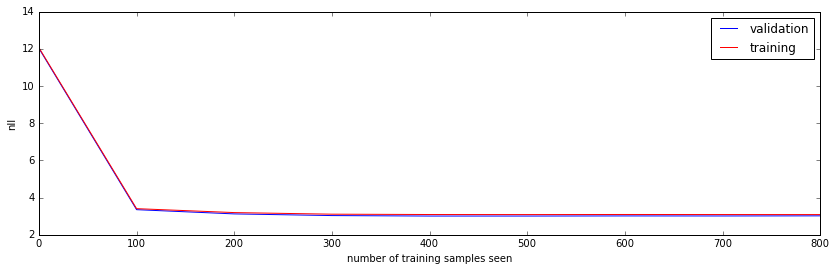

In [33]:
plt.figure(figsize=(14, 4))
plt.plot(n_samples_seen, val_losses, c='b', label='validation')
plt.plot(n_samples_seen, train_losses, c='r', label='training')
plt.ylabel('nll'),
plt.xlabel('number of training samples seen'),
plt.legend(loc='best');

In [34]:
mu.eval()

array([ 1.07988739,  0.94660413], dtype=float32)

In [35]:
np.linalg.inv(P.eval())

array([[ 1.23526943, -0.72968018],
       [-0.72968018,  1.62443793]], dtype=float32)

In [36]:
nll_loss.eval(feed_dict={X: X_train}), nll_loss.eval(feed_dict={X: X_test})

(3.0873237, 3.0107942)

Let's compare the results to a simplem multi-variate Gaussian fitted using the classical EM algorithm as implemented in scikit-learn:

In [37]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=1, reg_covar=0, covariance_type='full').fit(X_train)
gm.score(X_train), gm.score(X_test)

(-3.0834081053541653, -3.0015422508342327)

In [38]:
gm.means_

array([[ 1.07367587,  0.91891202]])

In [39]:
gm.covariances_

array([[[ 1.38536061, -0.82936625],
        [-0.82936625,  1.6760251 ]]])

In [40]:
gm.weights_

array([ 1.])

The results look similar.

## Fitting a mixture of Gaussian components

Let's put the code in a class that is loosely inspired by the scikit-learn Estimator API instead of implementing this in notebook cells. The companion `gmmsgd.py` file hosts an implementation of a mixture model where each Gaussian component is parameterized as previously and the mixture weights are parametrized with a softmax. First let's check that it works as expected with a single component:

In [41]:
%%time
from gmmsgd import GaussianMixtureSGD

gm_sgd = GaussianMixtureSGD(n_components=1, batch_size=10, session=sess)
gm_sgd.fit(X_train, X_val=X_val)

print(gm_sgd.n_iter_, gm_sgd.score(X_train), gm_sgd.score(X_test))

6 -3.08451 -3.00099
CPU times: user 332 ms, sys: 68 ms, total: 400 ms
Wall time: 316 ms


In [42]:
print(X_train.shape)

(100, 2)


In [43]:
gm_sgd.score_samples(X_train).shape

(100,)

In [44]:
gm_sgd.score_samples(X_train).mean()

-3.0845127

In [45]:
for name, variables in gm_sgd._component_variables.items():
    print(name)
    for var in variables:
        print(var.eval())
    if name == 'P':
        print('C')
        for var in variables:
            print(np.linalg.inv(var.eval()))

P
[[ 0.98528486  0.50272858]
 [ 0.50272858  0.83575851]]
C
[[ 1.46438253 -0.88086087]
 [-0.88086087  1.72637653]]
d
[-0.00741227 -0.2730124 ]
mu
[ 1.05798376  0.95076191]


In [46]:
gm_sgd._normalized_weights.eval()

array([ 1.], dtype=float32)

Let's try with a more complex dataset:

In [47]:
from sklearn.model_selection import train_test_split

X = np.vstack([
    rng.multivariate_normal(mean=[1, 1], cov=[[1.5, -.9], [-.9, 1.5]],
                            size=1000),
    rng.multivariate_normal(mean=[-2, 0], cov=[[1, 0], [0, 1]],
                            size=2000),
]).astype(np.float32)

X_trainval, X_test = train_test_split(X, test_size=0.5, random_state=0)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=0)

In [48]:
X_train.shape

(1200, 2)

In [49]:
X_test.shape

(1500, 2)

In [50]:
X_trainval.shape

(1500, 2)

In [84]:
%%time
gm_sgd = GaussianMixtureSGD(n_components=2, learning_rate=0.1, batch_size=10,
                            means_init=[[1, 1], [-2, 0]], session=sess)
gm_sgd.fit(X_train, X_val=X_val)

print(gm_sgd.n_iter_, gm_sgd.score(X_train), gm_sgd.score(X_test))

P
[[ 0.01831564  0.        ]
 [ 0.          0.01831564]]
[[ 0.01831564  0.        ]
 [ 0.          0.01831564]]
C
[[ 54.59814835   0.        ]
 [  0.          54.59814835]]
[[ 54.59814835   0.        ]
 [  0.          54.59814835]]
d
[-2. -2.]
[-2. -2.]
mu
[ 1.  1.]
[-2.  0.]
1 -3.57729 -3.61916
CPU times: user 996 ms, sys: 240 ms, total: 1.24 s
Wall time: 965 ms


In [85]:
for name, variables in gm_sgd._component_variables.items():
    print(name)
    for var in variables:
        print(var.eval())
    if name == 'P':
        print('C')
        for var in variables:
            print(np.linalg.inv(var.eval()))

P
[[ 0.33429468 -0.06078098]
 [-0.06078098  0.96266949]]
[[ 0.30148795 -0.21622829]
 [-0.21622829  1.03142524]]
C
[[ 3.0261116   0.19106248]
 [ 0.19106248  1.05084145]]
[[ 3.90384388  0.81840295]
 [ 0.81840295  1.14110243]]
d
[-0.54786623 -0.02479559]
[-0.59951264 -0.06599743]
mu
[-1.1412251   0.33954874]
[-1.04856408  0.45692226]


In [79]:
gm_sgd._normalized_weights.eval()

array([ 0.27814388,  0.72185618], dtype=float32)

In [80]:
%%time

gm = GaussianMixture(n_components=2, covariance_type='full', tol=1e-3).fit(X_train)
print(gm.n_iter_, gm.score(X_train), gm.score(X_test))

1 -3.37090932996 -3.45030319871
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 8.41 ms


In [73]:
gm.means_

array([[-2.01570783, -0.08984559],
       [ 0.96672288,  0.99413359]])

In [65]:
gm.covariances_

array([[[ 1.40508253, -0.73892728],
        [-0.73892728,  1.31813992]],

       [[ 0.86448288, -0.01104112],
        [-0.01104112,  0.93748487]]])

In [66]:
gm.weights_

array([ 0.35482407,  0.64517593])